In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1_AWAY']:
            if row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1_AWAY']:
            if row['SPREAD'] < row['SPREAD_1_AWAY']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1_AWAY']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2_AWAY']:
            if row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2_AWAY']:
            if row['SPREAD'] < row['SPREAD_2_AWAY']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2_AWAY']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4_AWAY']:
            if row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4_AWAY']:
            if row['SPREAD'] < row['SPREAD_4_AWAY']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4_AWAY']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [4]:
def eval_model(model, X_train, y_train, X_test, X_test_game_ids):
    #create df of actual spreads, predicted spreads, and betting spreads
    model = model.fit(X_train, y_train)
    
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    spread_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    spread_eval_df = spread_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    #convert betting spreads to floats
    spread_eval_df['SPREAD_1_AWAY'] = spread_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_2_AWAY'] = spread_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    spread_eval_df['SPREAD_4_AWAY'] = spread_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #compute winning percentages for each book
    results1, results2, results4 = calc_bet_winning_percentages(spread_eval_df)
    print('Winning percentage on book 1: ', results1)
    print('Winning percentage on book 2: ', results2)
    print('Winning percentage on book 4: ', results4)

In [5]:
#read in dataset
#df = pd.read_csv('moving_average_df_60.csv')
df = pd.read_csv('weighted_average_df_50.csv')


In [6]:
#import betting spreads data
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
spreads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 0 to 6235
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GM_DATE        6236 non-null   object
 1   HOME_TEAM      6236 non-null   object
 2   SPREAD_1_AWAY  5938 non-null   object
 3   ODDS_1_AWAY    6117 non-null   object
 4   SPREAD_2_AWAY  2100 non-null   object
 5   ODDS_2_AWAY    6236 non-null   object
 6   SPREAD_3_AWAY  569 non-null    object
 7   ODDS_3_AWAY    6236 non-null   object
 8   SPREAD_4_AWAY  1198 non-null   object
 9   ODDS_4_AWAY    6236 non-null   object
 10  SPREAD_1_HOME  5938 non-null   object
 11  ODDS_1_HOME    6117 non-null   object
 12  SPREAD_2_HOME  2100 non-null   object
 13  ODDS_2_HOME    6236 non-null   object
 14  SPREAD_3_HOME  569 non-null    object
 15  ODDS_3_HOME    6236 non-null   object
 16  SPREAD_4_HOME  1195 non-null   object
 17  ODDS_4_HOME    6236 non-null   object
dtypes: object(18)
memory usage: 

In [8]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']
test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
0,42100404,2022-06-10,1610612738,Boston,-10
1,42100403,2022-06-08,1610612738,Boston,16
2,42100402,2022-06-05,1610612744,Golden State,19
3,42100401,2022-06-02,1610612744,Golden State,-12
4,42100307,2022-05-29,1610612748,Miami,-4


In [9]:
#create training dataset
train_df = df[df['SEASON'].isin(test_seasons)==False].copy()

In [10]:
#drop unnecessary columns
test_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)
train_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)

In [11]:
#separate spread actuals from training and testing data
X_train = train_df.drop(columns=['SPREAD','SEASON'])
y_train = train_df['SPREAD']
X_test = test_df.drop(columns=['SPREAD', 'SEASON'])
y_test = test_df['SPREAD']

In [12]:
X_train.head()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,...,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
6246,0.844694,42.500408,86.758163,0.491455,12.250408,31.956735,0.384059,18.036531,22.636122,0.800224,...,13.507592,0.569782,0.601669,1.0,0.198313,98.044529,96.349873,80.291016,97.432449,0.515049
6247,0.595102,40.550000,83.538980,0.486633,13.374490,34.242653,0.389534,17.631837,23.063265,0.763344,...,14.163918,0.563382,0.598640,1.0,0.199193,101.813441,99.971990,83.310161,100.171429,0.580282
6248,0.617347,40.644286,83.395510,0.488493,13.434286,33.973878,0.393270,17.485102,22.985102,0.759662,...,14.008327,0.564362,0.598881,1.0,0.199126,101.742673,99.984765,83.320673,100.205102,0.581839
6249,0.864898,42.619796,86.727551,0.493019,11.988163,31.286327,0.383460,17.667347,22.271224,0.796051,...,13.829306,0.571541,0.603082,1.0,0.198278,97.451904,95.890282,79.907957,97.042857,0.518685
6250,0.851633,42.529592,86.154490,0.494792,11.948980,31.224082,0.382877,17.815306,22.440612,0.797411,...,13.603531,0.575562,0.606390,1.0,0.198192,97.391047,95.811812,79.842655,97.002857,0.524906


In [13]:
#Standardize features
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,GAME_ID,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,42100404,1.413704,1.044947,0.376906,1.245185,2.331434,2.104412,0.988400,-0.033979,-0.558799,...,2.381133,2.176767,0.0,-1.064538,1.017943,0.955003,0.954984,0.797447,0.559968,-10
1,42100403,1.378733,1.021899,0.339402,1.257941,2.344492,2.113459,0.999176,-0.034789,-0.598904,...,2.417330,2.214301,0.0,-1.165484,1.053303,0.983528,0.983508,0.832053,0.687866,16
2,42100402,0.647046,1.603674,0.836138,1.674835,2.199639,2.025784,1.081231,-1.117218,-1.241636,...,2.424450,2.615122,0.0,-0.616769,0.639651,0.563612,0.563734,0.406542,1.980002,19
3,42100401,0.790963,1.644620,0.813177,1.776878,2.172381,1.995303,1.110627,-1.047940,-1.177803,...,2.371975,2.561794,0.0,-0.611743,0.645082,0.590288,0.590391,0.439287,1.976593,-12
4,42100307,0.922774,0.615729,0.369711,0.647265,1.707137,1.787801,0.134947,-0.136783,-0.644239,...,2.410148,2.609872,0.0,-0.855523,0.638902,0.592857,0.593006,0.442517,1.960262,-4


Text(0, 0.5, 'cumulative explained variance')

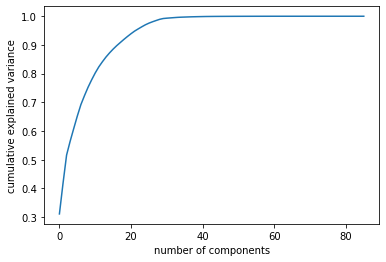

In [14]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

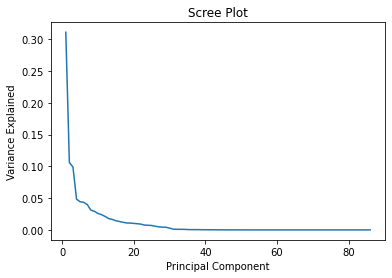

In [15]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [16]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)]

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,10.222099,2.332947,-4.273636,-0.292251,-0.810580,-0.370771,1.082059,-2.406735,0.386081,-0.994919,...,-0.931272,0.777585,0.402800,0.833771,-0.619486,0.370383,1.388010,-0.774479,42100404,-10
1,10.402199,1.970282,-4.437071,-0.203186,-0.526463,-0.378201,0.992589,-2.433517,0.198685,-1.100418,...,-1.005617,0.758444,0.441741,0.871694,-0.754954,0.433853,1.465392,-0.765684,42100403,16
2,10.633668,-2.173903,-4.811731,-0.221055,0.441511,-0.081776,-1.118075,-2.264494,-0.392846,-0.974686,...,1.380034,-0.844614,0.342245,-0.565509,-0.810274,0.653799,-1.249018,-0.697734,42100402,19
3,10.654325,-1.860235,-4.926863,-0.020887,0.482520,-0.067390,-1.186487,-2.223089,-0.477874,-1.129574,...,1.455316,-0.866210,0.499250,-0.565442,-0.904264,0.674058,-1.297729,-0.627930,42100401,-12
4,8.513710,-3.235284,-4.733605,-1.310827,0.382388,0.303578,0.823990,-1.274411,0.338282,-1.384971,...,0.257665,0.409107,0.565336,-0.341262,-2.627843,0.906301,-2.151861,-1.024094,42100307,-4


In [87]:
#split pca data into train and test
test_ids_set = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_ids_set)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_ids_set)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6246,10.592953,3.557452,-5.537966,-0.262972,-1.384508,0.443525,-1.767893,-2.347051,-2.586335,-0.458672,2.915120,-0.202873,-1.433566,1.889472,-0.885642,0.234215,1.054764,0.036084,0.653830,0.099779
6247,10.513532,-3.678944,-5.857229,-0.059258,1.327257,-0.035408,1.772671,-2.319269,2.745136,-0.634293,-2.824446,-0.319599,1.622212,-1.896789,-0.814546,-0.132691,1.062896,0.052985,-0.611467,-0.113746
6248,10.765944,-3.536339,-6.265462,-0.037059,1.234927,-0.286156,1.742111,-2.293292,2.559403,-0.640302,-2.815793,-0.201104,1.763873,-1.993449,-0.926070,-0.035030,1.111724,0.071193,-0.609058,0.108192
6249,10.498575,3.803192,-6.229778,-0.168331,-0.986117,-0.149400,-1.886126,-2.219024,-2.332707,-0.948539,3.064845,-0.334990,-1.981957,2.328243,-1.027273,-0.033386,1.270323,0.152239,0.586860,0.308096
6250,10.609427,3.151566,-6.445943,-0.308127,-1.407049,0.033889,-1.975614,-2.449337,-2.468753,-1.268474,2.787966,-0.331832,-1.838840,2.045161,-1.192586,0.167037,1.207939,0.195202,0.739406,0.381096


In [88]:
#polynomial regression
degree = 1
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg_baseline_score = cross_val_score(poly_reg, X_train_poly, y_train_pca, cv=5)
print('Polynomial regression baseline CV scores: ', poly_reg_baseline_score)
print('Polynomial regression baseline avg. CV score: ', poly_reg_baseline_score.mean())

Polynomial regression baseline CV scores:  [0.16630251 0.17770611 0.18772403 0.1150093  0.14345381]
Polynomial regression baseline avg. CV score:  0.1580391532284327


In [89]:
#DELETE CELL
#evaluate baseline polynomical regression model
poly_reg = LinearRegression()
eval_model(poly_reg, X_train_poly, y_train_pca, X_test_poly, test_game_ids)

Winning percentage on book 1:  0.5048126503953249
Winning percentage on book 2:  0.5306024096385542
Winning percentage on book 4:  0.5172413793103449


In [90]:
#score on training and test data to check for overfitting
training_score = poly_reg.score(X_train_poly, y_train_pca)
test_score = poly_reg.score(X_test_poly, y_test_pca)

print('Training score: ', training_score)
print('Test score: ', test_score)

Training score:  0.16253695394108847
Test score:  0.13220351780890094


In [97]:
def eval_winnings(model, X_train, y_train, X_test, X_test_game_ids):
    #train model
    model.fit(X_train, y_train)
    
    #generate predictions with associated game ids
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    #create df with predicted spreads, actual spreads, and betting spreads
    winnings_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    winnings_eval_df = winnings_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    winnings_eval_df.drop(columns=['SPREAD_1_HOME', 'SPREAD_2_HOME','SPREAD_3_HOME','SPREAD_4_HOME'], inplace=True)
    
    #convert betting spreads to floats
    winnings_eval_df['SPREAD_1_AWAY'] = winnings_eval_df['SPREAD_1_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_2_AWAY'] = winnings_eval_df['SPREAD_2_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_3_AWAY'] = winnings_eval_df['SPREAD_3_AWAY'].apply(convert_to_float)
    winnings_eval_df['SPREAD_4_AWAY'] = winnings_eval_df['SPREAD_4_AWAY'].apply(convert_to_float)
    
    #find betting spread with largest discrepency with predicted spread
    spread_away = np.empty(len(winnings_eval_df))
    odds_away = np.empty(len(winnings_eval_df))
    odds_home = np.empty(len(winnings_eval_df))
    
    for i, row in winnings_eval_df.iterrows():
        
        spread_diff = {}
        
        if not np.isnan(row['SPREAD_1_AWAY']):
            spread_diff['SPREAD_1_AWAY'] = abs(row['SPREAD_1_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_2_AWAY']):
            spread_diff['SPREAD_2_AWAY'] = abs(row['SPREAD_2_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_3_AWAY']):
            spread_diff['SPREAD_3_AWAY'] = abs(row['SPREAD_3_AWAY'] - row['SPREADS_PRED'])
        if not np.isnan(row['SPREAD_4_AWAY']):
            spread_diff['SPREAD_4_AWAY'] = abs(row['SPREAD_4_AWAY'] - row['SPREADS_PRED'])
        
        if not spread_diff:
            continue
            
        book_num = max(spread_diff, key=spread_diff.get)[7]
        
        spread_away[i] = row['SPREAD_%s_AWAY'%book_num]
        odds_away[i] = row['ODDS_%s_AWAY'%book_num]
        odds_home[i] = row['ODDS_%s_AWAY'%book_num]
        
        
        
    winnings_eval_df.drop(columns=['SPREAD_1_AWAY',
                                   'ODDS_1_AWAY',
                                   'ODDS_1_HOME',
                                   'SPREAD_2_AWAY',
                                   'ODDS_2_AWAY',
                                   'ODDS_2_HOME',
                                   'SPREAD_3_AWAY',
                                   'ODDS_3_AWAY',
                                   'ODDS_3_HOME',
                                   'SPREAD_4_AWAY',
                                   'ODDS_4_AWAY',
                                   'ODDS_4_HOME',], inplace=True)
    
    winnings_eval_df['SPREAD_AWAY'] = spread_away
    winnings_eval_df['ODDS_AWAY'] = odds_away
    winnings_eval_df['ODDS_HOME'] = odds_home
    
    #sort dataframe by date
    winnings_eval_df.sort_values(by='GM_DATE', inplace=True, ignore_index=True)

    #initialize starting bankroll and bet amount
    bankroll = 1000
    bet_amt = 5
    
    bankroll_trended = np.empty(len(winnings_eval_df))
    bankroll_trended[0] = bankroll
    wins = np.empty(len(winnings_eval_df))
    
    #compute winnings
    for i, row in winnings_eval_df.iterrows():
        
        if row['SPREADS_PRED'] > row['SPREAD_AWAY']:
            if row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = 0
                winnings = -bet_amt
            elif row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_HOME'] < 0:
                    winnings = (100 / abs(row['ODDS_HOME'])) * bet_amt
                elif row['ODDS_HOME'] > 0:
                    winnings = (row['ODDS_HOME'] / 100) * bet_amt
                
        elif row['SPREADS_PRED'] < row['SPREAD_AWAY']:
            if row['SPREAD'] > row['SPREAD_AWAY']:
                wins[i] = 0
                winnings = -bet_amt
            elif row['SPREAD'] < row['SPREAD_AWAY']:
                wins[i] = 1
                if row['ODDS_AWAY'] < 0:
                    winnings = (100 / abs(row['ODDS_AWAY'])) * bet_amt
                elif row['ODDS_AWAY'] > 0:
                    winnings = (row['ODDS_AWAY'] / 100) * bet_amt
        
        bankroll += winnings
        bankroll_trended[i] = bankroll
    
    win_pct = sum(wins) / len(wins)
    bankroll_trended_df = pd.DataFrame({'date':winnings_eval_df['GM_DATE'], 'bankroll':bankroll_trended})
    
    return win_pct, bankroll_trended_df


In [98]:
#evaluate winnings from best model
best_model = LinearRegression()
win_pct, bankroll_trended_df = eval_winnings(best_model, X_train_poly, y_train_pca, X_test_poly, test_game_ids)
print('Win percentage: ', win_pct)

    GAME_ID     GM_DATE  TEAM_ID_HOME     HOME_TEAM  SPREAD  SPREADS_PRED  \
0  21700002  2017-10-17    1610612744  Golden State      -1     12.391969   
1  21700001  2017-10-17    1610612739     Cleveland       3      6.186048   
2  21700008  2017-10-18    1610612763       Memphis      12      1.103013   
3  21700013  2017-10-18    1610612758    Sacramento      -5     -2.084938   
4  21700004  2017-10-18    1610612754       Indiana       9      6.512275   

   SPREAD_AWAY  ODDS_AWAY  ODDS_HOME  
0          2.5      270.0      270.0  
1         12.5     -345.0     -345.0  
2         -7.5      280.0      280.0  
3         -7.0     -110.0     -110.0  
4         -5.5      240.0      240.0  
Win percentage:  0.5130755655382641


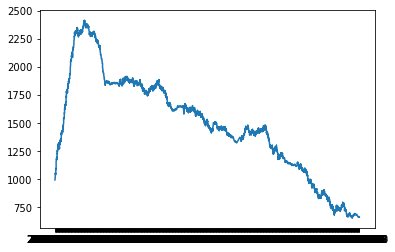

In [99]:
plt.plot(bankroll_trended_df['date'], bankroll_trended_df['bankroll'])

In [100]:
print(bankroll_trended_df)

            date     bankroll
0     2017-10-17   995.000000
1     2017-10-17   996.449275
2     2017-10-18  1010.449275
3     2017-10-18  1014.994730
4     2017-10-18  1026.994730
...          ...          ...
6228  2022-05-29   665.398598
6229  2022-06-02   669.784563
6230  2022-06-05   664.784563
6231  2022-06-08   669.330017
6232  2022-06-10   664.330017

[6233 rows x 2 columns]


In [101]:
bankroll_trended_df_17_18 = bankroll_trended_df[('2017-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2018-07-01')]
bankroll_trended_df_18_19 = bankroll_trended_df[('2018-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2019-07-01')]
bankroll_trended_df_19_20 = bankroll_trended_df[('2019-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2020-07-01')]
bankroll_trended_df_20_21 = bankroll_trended_df[('2020-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2021-07-01')]
bankroll_trended_df_21_22 = bankroll_trended_df[('2021-10-01'<bankroll_trended_df['date']) &
                                                (bankroll_trended_df['date']<'2022-07-01')]

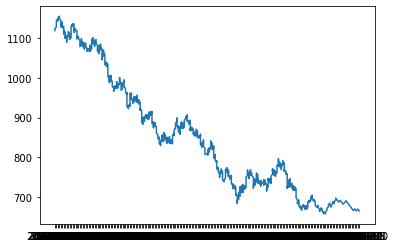

In [102]:
plt.plot(bankroll_trended_df_21_22['date'], bankroll_trended_df_21_22['bankroll'])

In [ ]:
#implement ridge regression
#ridge regression did not significantly improve performance of baseline linear regression
'''
ridge_reg = Ridge()
alpha = np.logspace(1e-5, 1, 100)
grid = {'alpha' : alpha}

ridge_reg = GridSearchCV(estimator=ridge_reg, param_grid=grid, cv=5, verbose=5)
ridge_reg.fit(X_train_poly, y_train_pca)
print('Best score: ', ridge_reg.best_score_)
'''

In [103]:
#Random Forrest implementation
#Baseline RF CV results

rf = RandomForestRegressor()
rf_score = cross_val_score(rf, X_train_pca, y_train_pca, cv=5)
print('Random Forest test scores: ', rf_score)
print('Random Forest avg. test score: ', rf_score.mean())

rf = RandomForestRegressor()
win_pct, bankroll_trended_df = eval_winnings(rf, X_train_poly, y_train_pca, X_test_poly, test_game_ids)
print('Win percentage: ', win_pct)

    GAME_ID     GM_DATE  TEAM_ID_HOME     HOME_TEAM  SPREAD  SPREADS_PRED  \
0  21700002  2017-10-17    1610612744  Golden State      -1         13.97   
1  21700001  2017-10-17    1610612739     Cleveland       3          4.26   
2  21700008  2017-10-18    1610612763       Memphis      12          1.36   
3  21700013  2017-10-18    1610612758    Sacramento      -5         -3.36   
4  21700004  2017-10-18    1610612754       Indiana       9          7.51   

   SPREAD_AWAY  ODDS_AWAY  ODDS_HOME  
0          2.5      270.0      270.0  
1         12.5     -345.0     -345.0  
2         -7.5      280.0      280.0  
3          1.5     -345.0     -345.0  
4         -5.5      240.0      240.0  
Win percentage:  0.48130916091769615


In [ ]:
#evaluate baseline random forest betting results
'''
rf = RandomForestRegressor()
test_game_ids = test_spreads_df['GAME_ID']
eval_model(rf, X_train_pca, y_train_pca, X_test_pca, test_game_ids)
'''

In [ ]:
#xgboost implementation
'''
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_predicts = xgb.predict(X_test)

print('XGBoost baseline: ', r2_score(y_test, xgb_predicts))
'''

In [ ]:
#eval_model(xgb, X_train, y_train, X_test, test_game_ids)

In [ ]:
#Tuned RF
#create hyperparameter grid

'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(50, 500, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=10, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''